In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

Import all the required libraries for this proect
Keep in mind you have to install the following libraries first before this code can be run

pip install tensorflow pandas numpy matplotlib yahoo_fin scikit-learn

In [84]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""

def generateModel(sequence_length, n_layers=2, neurons=256,
n_features=5, dropout=0.3, loss="mean_absolute_error", optimizer="rmsprop", layerType=LSTM):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(sequence_length, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


Generate the model by setting up all the parameters:

adjclose, volume, open, high and low as the 5 inputs of the model

In [134]:
# inputs used to predict the asset price
features = ["adjclose", "volume", "open", "high", "low"]
nFeatures = len(features)
# Window size (section that is taken into consideration?)
windowSize = 7 # 50
# amount of layers
layerNum = 3 # 2
# amount of neural netorks
neurons = 7 # 256
# drop out rate, e.g. 0.4 = 40%
dropout = 0.2 # 0.4
# type of loss function to be used
"""Huber looss is better to give outliers some weight but not too much,
which can be good for predicting asset prices?"""
lossFunc = "huber_loss"
# optimizezr to use
opt = "adam"
# main layers used
layers = LSTM

# model = generateModel(windowSize, layerNum, neurons)
model = generateModel(windowSize, layerNum, neurons,
n_features=nFeatures, dropout=dropout, loss=lossFunc, optimizer=opt, layerType=layers)

# display the model summary
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_193 (LSTM)             (None, 7, 7)              364       
                                                                 
 dropout_181 (Dropout)       (None, 7, 7)              0         
                                                                 
 lstm_194 (LSTM)             (None, 7, 7)              420       
                                                                 
 dropout_182 (Dropout)       (None, 7, 7)              0         
                                                                 
 lstm_195 (LSTM)             (None, 7)                 420       
                                                                 
 dropout_183 (Dropout)       (None, 7)                 0         
                                                                 
 dense_50 (Dense)            (None, 1)               

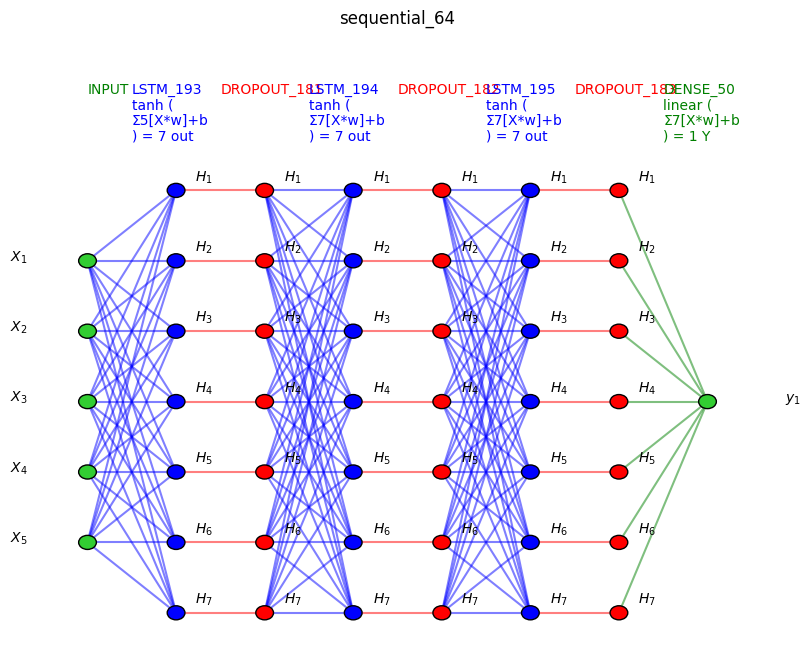

In [135]:
# import
from tensorflow.keras import models, layers, utils, backend as K 
import matplotlib.pyplot as plt
import numpy as np
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            # radius=y_space/4.0
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/10, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

visualize_nn(model, description=True, figsize=(10,8)) # 10 by 8

Importing the data to be used with the neural netowork

"get_data" from "stock_info" takes the arguments:
- ticker: case insensitive ticker of the desired stock/bond
- start_date: date you want the data to start from (mm/dd/yyyy)
- end_date: date you want the data to end (mm/dd/yyyy)
- index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
- interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

In [24]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
import datetime
import numpy as np

def setupData(ticker, days, inputs = ['adjclose', 'volume', 'open', 'high', 'low']):
    # setup the start date and end date
    startDate = datetime.datetime.now().date() - datetime.timedelta(days=days)
    endDate = datetime.datetime.now().date()
    print(endDate.weekday())

    # Get the data
    # data = yf.download(ticker, startDate, endDate)
    dataFrame = stock_info.get_data(ticker, startDate, endDate)

    print(f"Data is imported between {startDate} and the {endDate}, for a total of {days} days")

    nDays = len(dataFrame)
    if nDays < days:
        print(f"{nDays} days where found, hence a total of {days-nDays} days are missing when importing the data\n")

    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["fullDataframe"] = dataFrame.copy()

    # check that all the inputs exist
    # for input in inputs:
    #     assert input in dataFrame.columns, f"'{input}' does not exist in the dataframe."
    
    # add a date column onto our data frame
    if "date" not in dataFrame.columns:
        dataFrame["date"] = dataFrame.index
    
    # should we scale down between 0 and 1? It can make analysis easier
    # if scale:
    #     column_scaler = {}
    #     # scale the data (prices) from 0 to 1
    #     for column in feature_columns:
    #         scaler = preprocessing.MinMaxScaler()
    #         df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
    #         column_scaler[column] = scaler
    #     # add the MinMaxScaler instances to the result returned
    #     result["column_scaler"] = column_scaler

    # return the stocks that have been downloaded
    return data

# the number of days to look at, if you want a couple of years make it 365*2
days = 300
# Set the ticker
# ticker = "TSLA"
ticker = "AMZN"
dataFrame = setupData(ticker, days)

print(dataFrame)


0
Data is imported between 2022-02-01 and the 2022-11-28, for a total of 300 days
207 days where found, hence a total of 93 days are missing when importing the data

{'fullDataframe':                   open        high         low       close    adjclose  \
2022-02-01  150.000000  151.707993  147.627502  151.193497  151.193497   
2022-02-02  155.050507  155.074997  148.863495  150.612503  150.612503   
2022-02-03  141.737503  144.247498  138.332993  138.845505  138.845505   
2022-02-04  155.606506  161.199997  150.608002  157.639496  157.639496   
2022-02-07  158.520004  162.690994  157.250000  157.935501  157.935501   
...                ...         ...         ...         ...         ...   
2022-11-18   95.949997   95.989998   92.480003   94.139999   94.139999   
2022-11-21   93.970001   95.019997   90.589996   92.459999   92.459999   
2022-11-22   92.620003   93.349998   90.870003   93.199997   93.199997   
2022-11-23   93.239998   94.580002   92.830002   94.129997   94.129997   
20

In [ ]:

# Plot the adjusted close price
# data["Adj Close"].plot(figsize=(10, 7), marker = "*")
dataFrame['adjclose'].plot()

# Define the label for the title of the figure
plt.title("Adjusted Close Price of %s" % ticker, fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()

In [11]:
import numpy as np
from yahoo_fin import stock_info as si
from sklearn import preprocessing
from collections import deque
from sklearn.model_selection import train_test_split

def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result


In [42]:
ticker = "AMZN"
# Window size or the sequence length
N_STEPS = 50
# whether to scale feature columns & output price as well
SCALE = True
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
# whether to shuffle the dataset
SHUFFLE = True
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

for key in data:
    print(key)
print(data["column_scaler"]["adjclose"])


df
column_scaler
last_sequence
X_train
X_test
y_train
y_test
test_df
MinMaxScaler()


AttributeError: 'dict' object has no attribute 'tail'